# 08.3.线性回归的从零开始实现

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [3]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0,1,(num_examples,len(w)))#均值为0标准差为1，num个样本，列数为w的长度
    y = torch.matmul(X, w) + b #torch.matmul是矩阵乘法
    y += torch.normal(0,0.01,y.shape) #加上随机噪音
    return X, y.reshape((-1,1)) #-1表示自动计算，最终把y变成了一个列向量

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.6648,  0.5480]) 
label: tensor([1.0151])


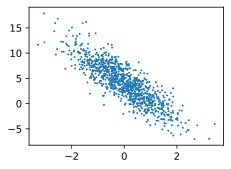

In [10]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),
                labels.detach().numpy(),1);